<a href="https://colab.research.google.com/github/JulianCKelly/steph-shot-predictor/blob/main/Steph_Shot_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from pandas.core.indexes.datetimes import DatetimeIndex
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [ ]:
#'''T1. Import DataFrame `df`'''

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, index_col= ['game_date'], parse_dates= ['game_date'])
# YOUR CODE HERE
df = pd.read_csv(url, index_col= ['game_date'], parse_dates= ['game_date'])

**Task 1 Testing**

In [ ]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [ ]:
#"""T2. Create new feature"""

# YOUR CODE HERE

Golden_State_Warriors = 'GSW'
home_court_advantage = df['htm'] == 'GSW'
opp = df['vtm']

df['period_rem_secs'] = ((df['minutes_remaining'] * 60) + df['seconds_remaining'])
total_period = 12 * 60
game_secs = total_period * 4
elapsed_secs = total_period - df['period_rem_secs']
df['game_rem_secs'] = game_secs - elapsed_secs
df = df.loc[:,~df.columns.duplicated()].copy()


**Task 2 Test**

In [ ]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [ ]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
X = df.drop(columns = 'shot_made_flag', axis = 1)
y = df['shot_made_flag']

**Task 3 Test**

In [ ]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [ ]:
'''T4. Create training and val'''
# YOUR CODE HERE
#X_train, X_val, y_train, y_val = train_test_split(X, y, random_state =42, test_size= .20)
# Split the dataset into training, validation, and test sets
X_train = df.loc['2009-10-01':'2017-06-30'].drop('shot_made_flag', axis=1)
y_train = df.loc['2009-10-01':'2017-06-30', 'shot_made_flag']

X_val = df.loc['2017-10-01':'2018-06-30'].drop('shot_made_flag', axis=1)
y_val = df.loc['2017-10-01':'2018-06-30', 'shot_made_flag']

X_test = df.loc['2018-10-01':'2019-06-30'].drop('shot_made_flag', axis=1)
y_test = df.loc['2018-10-01':'2019-06-30', 'shot_made_flag']


df.index

DatetimeIndex(['2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28',
               '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28',
               '2009-10-28', '2009-10-28',
               ...
               '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05',
               '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05',
               '2019-06-05', '2019-06-05'],
              dtype='datetime64[ns]', name='game_date', length=13958, freq=None)

**Test 4**

In [ ]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [ ]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()


**Task 5 Testing**

In [ ]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [ ]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
cat_features = ['period', 'htm', 'vtm', 'shot_type', 'shot_zone_basic', 'shot_zone_area', 'shot_zone_range']
num_features = ['period_rem_secs', 'game_rem_secs', 'shot_distance']

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(use_cat_names=True, cols=cat_features))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))])

model.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['period_rem_secs',
                                                   'game_rem_secs',
                                                   'shot_distance']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(cols=['period',
                                                                                       'htm',
                                                                                       'vtm',
                                                                                       'shot_type',
                                                                                       'shot_zone_basic',
                                                                                       'shot_zone_area',
                                                                                       'shot_zone_range'],
                                                                                 use_cat_names=True))]),
                                                  ['period', 'htm', 'vtm',
                                                   'shot_type',
                                                   'shot_zone_basic',
                                                   'shot_zone_area',
                                                   'shot_zone_range'])])),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

**Task 6 Testing**

In [ ]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [ ]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9995487771861745
Validation Accuracy Score: 0.5308219178082192


**Task 7 Test**

In [ ]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [ ]:
'''T8. Tune model.'''

# YOUR CODE HERE
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_distributions = {'classifier__n_estimators': [10, 50, 100],
                       'classifier__max_samples': [0.25, 0.5, 0.75]}

random_search = RandomizedSearchCV(model, param_distributions, n_iter=3, cv=None, random_state=42)

random_search.fit(X_val, y_val)

test_acc = model.score(X_val, y_val)

print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.5308219178082192


**Task 8 Testing**

In [ ]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

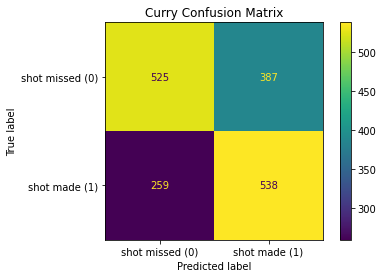

In [ ]:
'''T9. Calculate precision and recall'''
tp = 525
fp = 387
fn = 259

instructor_precision = tp / (tp + fp)
instructor_recall = tp / (tp + fn)

print('Instructor model precision', instructor_precision)
print('Instructor model recall', instructor_recall)

Instructor model precision 0.5756578947368421
Instructor model recall 0.6696428571428571


**Task 9 Testing**

In [ ]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

In [ ]:
import seaborn as sns

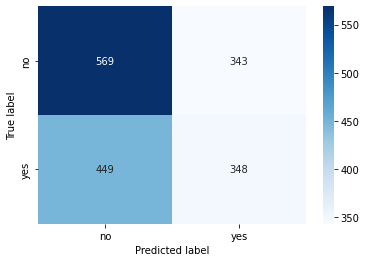

In [ ]:
'''T10. Plot ROC curve.'''
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
